##### Load imports and modules

In [ ]:
params = {
    # Dataset parameters
    "dataset": "dataset_half_notrim_tensors",
    "train_split": 0.6,
    "val_split": 0.2,
    "test_split": 0.2,
    
    # Preprocessing parameters
    'sample_rate': 16_000, 
    'min_freq': 0, 
    'max_freq': 8_000
}

MODEL_TYPE = "rnn_fft"
LOG_DIR = f"/content/marvin-models/logs/{MODEL_TYPE}"
LOG_LEVEL = "ERROR"
GH_TOKEN = "73a1d93fa1e7fe7696321a86ff037a0ecc58346c"

In [ ]:
#@markdown <b>Run me to import underscore module</b><br/>   {display-mode: "form"}
#@markdown <small>Method signatures:</small><br/> 
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _under(source_path, target_path, copy=True, auth_on_upload=True)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _set_gh_token(token)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _from_gh(user_name, repo_name, release_name) &nbsp; &nbsp; &nbsp; <b>Returns:</B> dictionary of arrays { 'array_name' : np.ndarray }</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs)</small></small><br/>
#@markdown <small><small>&nbsp; &nbsp; &nbsp; _export_model(model, model_name, model_type, val_dataset, test_dataset, params, hparams, history, log_dir, n_prep_layers=None)</small></small><br/>
!pip install -q tensorflowjs
!pip install -q githubrelease
import numpy as np
import os, glob, re, time, json
import github_release
import tensorflow.keras.backend as K
from contextlib import redirect_stdout

compressed_dirs = set()


def _compress(source_path, target_path, target_dir=None):
    if target_dir:
        !mkdir -p {target_dir}
    if target_path.endswith('.tar.gz'):
        !tar -czf {target_path} -C {source_path} .
    elif target_path.endswith('.tar'):
        !tar -cf {target_path} -C {source_path} .
    elif target_path.endswith('.zip'):
        !(cd {source_path} && zip -q -r {target_path} .)


def _extract(source_path, target_path):
    !mkdir -p {target_path}
    if source_path.endswith('.tar.gz'):
        !tar -xzf {source_path} -C {target_path}
    elif source_path.endswith('.tar'):
        !tar -xf {source_path} -C {target_path}
    elif source_path.endswith('.zip'):
        !unzip -qq {source_path} -d {target_path}


def _under(source_path, target_path, copy=True, auth_on_upload=True):
    """
    Use cases:
        Movement:
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Compression (e.g. from dir to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction (e.g. from .zip to dir):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
            
        Extraction & compression (e.g. from .zip to .tar.gz):
            - GCS -> GCS
            - GCS -> LOCAL
            - LOCAL -> GCS
            - LOCAL -> LOCAL
    """
    COMPRESSION_FORMATS = ('zip', 'tar', 'tar.gz')
    TEMP_DIR = "/tmp_"
    LOG_TEMPLATE = "{}    from    {}    to    {}"

    # Source
    if source_path.endswith("/"):
        source_path = source_path[:-1]
    source_dir, _, source_name = source_path.rpartition('/')
    source_isgcs = source_path.startswith("gs://")
    source_islocal = not source_isgcs
    if source_islocal:
        source_path = os.path.abspath(source_path)
    source_isprefix, source_isfile, source_ext = source_name.partition('.')
    source_isdir = not source_isfile
    source_iscompression = source_ext in COMPRESSION_FORMATS

    # Target
    target_dir, _, target_name = target_path.rpartition('/')
    target_isgcs = target_path.startswith("gs://")
    target_islocal = not target_isgcs
    target_prefix, target_isfile, target_ext = target_name.partition('.')
    target_isdir = not target_isfile
    target_iscompression = target_ext in COMPRESSION_FORMATS

    # Flags
    MOVE_ONLY = source_ext == target_ext
    GCS_ONLY = source_isgcs and target_isgcs
    RENAME = source_isprefix != target_prefix
    COMPRESSION = source_isdir and target_iscompression
    EXTRACTION = source_iscompression and target_isdir
    EXTRACTION_COMPRESSION = source_iscompression and target_iscompression and source_ext != target_ext

    # Add forward slash if file is at root level
    source_dir = "/" if not source_dir else source_dir
    target_dir = "/" if not target_dir else target_dir

    # Authenticate if writing to GCS
    if target_isgcs and auth_on_upload:
        from google.colab import auth
        auth.authenticate_user()

    # Assert that subdirectories exist if target is local
    if target_islocal:
        !mkdir -p {target_dir}

    # Movement commands
    if MOVE_ONLY:
        # GCS -> GCS
        if source_isgcs and target_isgcs:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                !gsutil -m -q mv {source_path} {target_path}
        
        # LOCAL -> LOCAL
        elif source_islocal and target_islocal:
            action = "COPYING" if copy else "MOVING"
            print(LOG_TEMPLATE.format(f"{action} (1/1)", source_path, target_path))
            if copy:
                !cp -r {source_path} {target_path}
            else:
                !mv {source_path} {target_path}
        
        # GCS -> LOCAL
        elif source_isgcs and target_islocal:
            if source_isdir:
                print(LOG_TEMPLATE.format("DOWNLOADING DIR (1/1)", source_path, target_dir))
                !gsutil -m -q cp -r {source_path} {target_dir}
                if RENAME:
                    print(LOG_TEMPLATE.format("\tRENAMING DIR", source_isprefix, target_prefix))
                    !mv {target_dir}/{source_isprefix} {target_dir}/{target_prefix}
            else:
                print(LOG_TEMPLATE.format("DOWNLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        
        # LOCAL -> GCS
        if source_islocal and target_isgcs:
            if source_isdir:
                print(LOG_TEMPLATE.format("UPLOADING DIR (1/1)", source_path, target_path))
                !gsutil -m -q cp -r {source_path} {target_path}
            else:
                print(LOG_TEMPLATE.format("UPLOADING FILE (1/1)", source_path, target_path))
                !gsutil -m -q cp {source_path} {target_path}
        return


    # Create directory for intermediate storage if required
    if source_isgcs or target_isgcs or EXTRACTION_COMPRESSION:
        !mkdir -p {TEMP_DIR}
    

    # For remaining operations, download GCS source to temp and treat as local
    if source_isgcs:
        if source_isdir:
            print(LOG_TEMPLATE.format("\tDOWNLOADING DIR", source_path, TEMP_DIR))
            !gsutil -m -q cp -r {source_path} {TEMP_DIR}
        else:
            print(LOG_TEMPLATE.format("\tDOWNLOADING FILE", source_path, f"{TEMP_DIR}/{source_name}"))
            !gsutil -m -q cp {source_path} {TEMP_DIR}/{source_name}
        source_path = f"{TEMP_DIR}/{source_name}"
        source_dir = TEMP_DIR

    # Compression
    if COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("COMPRESSING (1/1)", source_path, target_path))
            _compress(source_path, target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("COMPRESSING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _compress(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}

    # Extraction
    elif EXTRACTION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/1)", source_path, target_path))
            _extract(source_path, target_path)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_name}"))
            _extract(source_path, f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING DIR (2/2)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp -r {TEMP_DIR}/{target_name} {target_path}

    # Extraction & compression
    elif EXTRACTION_COMPRESSION:
        if target_islocal:
            print(LOG_TEMPLATE.format("EXTRACTING (1/2)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/2)", f"{TEMP_DIR}/{target_prefix}", target_path))
            _compress(f"{TEMP_DIR}/{target_prefix}", target_path, target_dir=target_dir)
        else:
            print(LOG_TEMPLATE.format("EXTRACTING (1/3)", source_path, f"{TEMP_DIR}/{target_prefix}"))
            _extract(source_path, f"{TEMP_DIR}/{target_prefix}")
            print(LOG_TEMPLATE.format("COMPRESSING (2/3)", f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}"))
            _compress(f"{TEMP_DIR}/{target_prefix}", f"{TEMP_DIR}/{target_name}")
            print(LOG_TEMPLATE.format("UPLOADING FILE (3/3)", f"{TEMP_DIR}/{target_name}", target_path))
            !gsutil -m -q cp {TEMP_DIR}/{target_name} {target_path}
    
    # Cleanup intermediate storage
    !rm -rf {TEMP_DIR}

def _set_gh_token(token):
    os.environ["GITHUB_TOKEN"] = token


def _export_array(array, release_name, prefix="", splits=3):
    dir_path = f"/tmp_/{release_name}"
    !mkdir -p {dir_path}
    n_digits = len(str(splits - 1))
    subarrays = np.array_split(array, splits)
    for i, subarray in enumerate(subarrays):
        filename = f"{prefix}__{str(i).zfill(n_digits)}.npy"
        np.save(f"{dir_path}/{filename}", subarray)


def _concat_arrays(paths):
    return np.concatenate([np.load(path, allow_pickle=True) for path in sorted(paths)])


def _to_gh(user_name, repo_name, release_name, split_size=600, **arr_kwargs):
    # Assert that GitHub Auth token is set
    if "GITHUB_TOKEN" not in os.environ:
        print("GitHub authentication token is not set.")
        print("Set token using the '_set_gh_token(token_string)' method.")
        print("Minimal required auth scope is 'repo/public_repo' for public repositories.")
        print("URL: https://github.com/settings/tokens/new")
        return

    # Split arrays
    for prefix, array in arr_kwargs.items():
        splits = int((array.nbytes/1_000_000) // split_size) + 1
        _export_array(array, release_name, prefix=prefix, splits=splits)

    # Upload arrays
    github_release.gh_release_create(
        f"{user_name}/{repo_name}", 
        release_name, 
        publish=True, 
        name=release_name, 
        asset_pattern=f"/tmp_/{release_name}/*"
    )
    !rm -rf /tmp_/*


def _from_gh(user_name, repo_name, release_name):
    # Download release to temporary directory
    print("Downloading dataset in parallell ... ", end='\t')
    t0 = time.perf_counter()
    assets = github_release.get_assets(f"{user_name}/{repo_name}", tag_name=release_name)
    download_urls = [asset['browser_download_url'] for asset in assets]
    urls_str = " ".join(download_urls)
    !echo {urls_str} | xargs -n 1 -P 8 wget -q -P /tmp_/{release_name}_dl/
    t1 = time.perf_counter()
    print(f"done! ({t1 - t0:.3f} seconds)")

    # Load data into numpy arrays
    paths = glob.glob(f"/tmp_/{release_name}_dl/*.npy")
    groups = {}
    for path in paths:
        match = re.match(r".*/(.*)__[0-9]*\.npy", path)
        if match:
            prefix = match.group(1)
            groups[prefix] = groups.get(prefix, []) + [path]
    arrays_dict = {name: _concat_arrays(paths) for name, paths in groups.items()}
    !rm -rf /tmp_/*
    return arrays_dict
    

def _log_to_gh(user, repo, tag, log_dir="/tmp/logs"):
    # Create temporary directory for compressed logs
    !mkdir -p /tmp/compressed_logs
    
    # Compress all directories in log dir
    for dirname in os.listdir(log_dir):
        # Skip files
        if "." in dirname or dirname in compressed_dirs:
            continue

        # Compress
        _under(f"{log_dir}/{dirname}", f"/tmp/compressed_logs/{dirname}.tar.gz")
        compressed_dirs.add(dirname)

    # Upload compressed logs to GitHub
    github_release.gh_asset_upload(f"{user}/{repo}", tag, f"/tmp/compressed_logs/*.tar.gz")

    # Cleanup compressed logs
    !rm -rf /tmp/compressed_logs/*

def timeit(method):
    def timed(*args, **kw):
        ts = time.perf_counter()
        result = method(*args, **kw)
        te = time.perf_counter()
        diff = te - ts
        print(f"{method.__name__}: {diff:.8f} s")
        return result
    return timed

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NpEncoder, self).default(obj)

@timeit
def _export_model(model, model_name, model_type, val_dataset, test_dataset, params, hparams, history, log_dir, n_prep_layers=None):
    # Create temporary directory
    target_dir = f"/tmp/models/{model_type}/{model_name}"
    !mkdir -p {target_dir}     #/tmp_/models/rnn_naive/rnn_naive_20201108_130308

    # Write export logs to file
    export_logs_path = os.path.join(target_dir, "export_logs.txt")
    with open(export_logs_path, 'w') as export_logs:
        with redirect_stdout(export_logs):
            # Profile model on inputs (average of n_runs cycles)
            n_runs = 5
            input_shape = val_dataset.element_spec[0].shape

            def time_examples(model, n):
                dummy = np.random.rand(n, *input_shape[1:])
                t0 = time.perf_counter()
                model.predict(dummy)
                return time.perf_counter() - t0

            with tf.device('/CPU:0'):
                cpu_profiles = {
                    "cpu_1": np.array([time_examples(model, 1) for _ in range(n_runs)]).mean(),
                    "cpu_10": np.array([time_examples(model, 10) for _ in range(n_runs)]).mean(),
                    "cpu_100": np.array([time_examples(model, 100) for _ in range(n_runs)]).mean()
                }

            with tf.device('/GPU:0'):
                gpu_profiles = {
                    "gpu_1": np.array([time_examples(model, 1) for _ in range(n_runs)]).mean(),
                    "gpu_10": np.array([time_examples(model, 10) for _ in range(n_runs)]).mean(),
                    "gpu_100": np.array([time_examples(model, 100) for _ in range(n_runs)]).mean()
                }

            # Get number of parameters
            params_counts = {
                "trainable_params": np.sum([K.count_params(w) for w in model.trainable_weights]),
                "non_trainable_params": np.sum([K.count_params(w) for w in model.non_trainable_weights])
            }
            params_counts["total_params"] = params_counts["trainable_params"] + params_counts["non_trainable_params"]

            # Generate evaluation metrics for validation and test set
            final_metrics_val = model.evaluate(val_dataset, return_dict=True)
            final_metrics_val = {f"final_val_{k}": v for k, v in final_metrics_val.items()}
            final_metrics_test = model.evaluate(test_dataset, return_dict=True)
            final_metrics_test = {f"final_test_{k}": v for k, v in final_metrics_test.items()}

            # Generate Dataframe and export to parquet
            logs_params = {
                **params,
                **hparams,
                **history.params,
                **cpu_profiles,
                **gpu_profiles,
                **params_counts,
                **final_metrics_val,
                **final_metrics_test
            }
            logs_df = pd.DataFrame({**history.history, "epoch": history.epoch})
            for param, value in logs_params.items():
                logs_df[param] = value
            logs_df.to_parquet(os.path.join(target_dir, f"{model_name}.parquet"))

            # Dump all parameters and metadata to .json file
            with open(os.path.join(target_dir, 'model_details.json'), 'w') as f:
                json.dump(logs_params, f, cls=NpEncoder, indent=4)

            def _convert_model(model, subdir="model"):
                # Create subdirectory
                subdir_path = os.path.join(target_dir, subdir)
                !mkdir -p {subdir_path}

                # Write model summary to file
                model_summary_path = os.path.join(subdir_path, "model_summary.txt")
                with open(model_summary_path, 'w') as model_summary:
                    with redirect_stdout(model_summary):
                        model.summary()

                # Export model summary as image
                model_summary_img_path = os.path.join(subdir_path, "model_summary.png")
                tf.keras.utils.plot_model(model, to_file=model_summary_img_path, show_shapes=True)

                # Generate model paths
                keras_model_path = os.path.join(subdir_path, "keras_model.h5")
                saved_model_path = os.path.join(subdir_path, "saved_model")
                tfjs_layers_model_path = os.path.join(subdir_path, "tfjs_layers_model")
                tfjs_graph_model_path = os.path.join(subdir_path, "tfjs_graph_model")

                # Save and convert model
                model.save(keras_model_path)
                tf.saved_model.save(model, saved_model_path)
                !tensorflowjs_converter --input_format=keras --output_format=tfjs_layers_model {keras_model_path} {tfjs_layers_model_path}
                !tensorflowjs_converter --input_format=tf_saved_model --output_format=tfjs_graph_model {saved_model_path} {tfjs_graph_model_path}
            
            # Convert full model
            _convert_model(model, subdir="model")

            if n_prep_layers is not None:
                model_1 = tf.keras.Sequential(model.layers[:n_prep_layers])
                model_1.build(input_shape=input_shape)
                
                model_2 = tf.keras.Sequential(model.layers[n_prep_layers:])
                model_2.build(input_shape=model_1.layers[-1].output_shape)

                # Convert models
                _convert_model(model_1, subdir="submodel_1")
                _convert_model(model_2, subdir="submodel_2")

            # Compress TensorBoard logs
            model_log_dir = os.path.join(LOG_DIR, model_name)
            tensorboard_logs_path = os.path.join(target_dir, f"{model_name}.tar.gz")
            _under(model_log_dir, tensorboard_logs_path)

    # Upload logs to GCS
    _under(target_dir, f"gs://marvin-voice/models/{model_type}/{model_name}", auth_on_upload=False)
    return logs_df

     |████████████████████████████████| 71kB 5.0MB/s 
     |████████████████████████████████| 112kB 10.9MB/s 


In [ ]:
# Download git repository
import os
if not os.getcwd().endswith("marvin-models"):
    !git config --global user.email "patrikkja@gmail.com"
    !git config --global user.name "Patrik Kjærran"
    !git clone -q https://github.com/patrikkj/marvin-models.git
    %cd marvin-models

# Internal modules
import io, sys, glob, time
from datetime import datetime
from importlib import reload

# External modules
!pip install -q pydub
!pip install -q tensorflow-io
#!pip install -q -U tensorboard_plugin_profile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_io as tfio
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, LearningRateScheduler
from tensorboard.plugins.hparams import api as hp

# Colab modules
from google.colab import auth
from IPython import display
    
# Scripts (record_audio requires pydub installed)
import scripts

# Set random number generation seeds
np.random.seed(1)
tf.random.set_seed(1)

# Enable logging to GitHub release tag
_set_gh_token(GH_TOKEN)

# Set logging level
!mkdir -p {LOG_DIR}
tf.get_logger().setLevel(LOG_LEVEL)

/content/marvin-models
     |████████████████████████████████| 22.4MB 1.5MB/s 


##### Download dataset


In [ ]:
if 'arrays' not in globals():
    arrays = _from_gh("patrikkj", "marvin-models", params['dataset'])
    pos_data, pos_labels = arrays['pos_data'], arrays['pos_labels']
    neg_data, neg_labels = arrays['neg_data'], arrays['neg_labels']

    # Dataset characteristics
    classes = np.array([0, 1])
    split = [params['train_split'], params['val_split'], params['test_split']]

    # Build dataset
    arrays, info = scripts.datasets.build_dataset(pos_data, pos_labels, neg_data, neg_labels, split)
    TRAIN_SIZE, VAL_SIZE, TEST_SIZE = info
    POS_SIZE = pos_data.shape[0]
    NEG_SIZE = neg_data.shape[0]
    TOTAL_SIZE = POS_SIZE + NEG_SIZE

##### Build TensorFlow graph


In [ ]:
cell_types = {
    'gru': tf.keras.layers.GRU,
    'lstm': tf.keras.layers.LSTM,
    'bi-gru': lambda *args, **kwargs: tf.keras.layers.Bidirectional(tf.keras.layers.GRU(*args, **kwargs)),
    'bi-lstm': lambda *args, **kwargs: tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(*args, **kwargs)),
}

optimizers = {
    'adam': tf.keras.optimizers.Adam,
    'rmsprop': tf.keras.optimizers.RMSprop,
    'sgd': tf.keras.optimizers.SGD
}

def build_model(params, hparams, output_bias):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(params['sample_rate'],), dtype=tf.float32))

    # Create preprocessing model
    preprocessing = tf.keras.Sequential([
        scripts.layers.Spectrogram(params, hparams),
        scripts.layers.MelSpectrogram(params, hparams),
        scripts.layers.LogMelSpectrogram(params, hparams),
    ], name="DataPreprocessing")
    model.add(preprocessing)

    # Create augmentation model
    augmentation = tf.keras.Sequential([
        scripts.layers.FrequencyMask(params, hparams),
        scripts.layers.TimeMask(params, hparams),
    ], name="DataAugmentation")
    model.add(augmentation)

    # Convolutional units
    model.add(tf.keras.layers.Conv1D(hparams['conv_filters'], hparams['conv_kernel_size'], strides=hparams['conv_stride'], activation='relu'))

    # Recurrent units
    for _ in range(hparams['recurrent_layers'] - 1):
        model.add(cell_types[hparams['recurrent_cell']](hparams['recurrent_units'], return_sequences=True))
    model.add(cell_types[hparams['recurrent_cell']](hparams['recurrent_units']))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
    return model

def train_model(params, hparams, metrics, log_dir, model_type, output_bias=None, **fit_kwargs):
    # Prepare output bias for imbalanced distributions
    if output_bias is not None:
        output_bias = None if output_bias == 0 else tf.keras.initializers.Constant(output_bias)

    # Create callbacks and prepare logging
    early_stopping = EarlyStopping(patience=20, restore_best_weights=True, verbose=1)
    timestamp = datetime.now()
    dir_name = f"{model_type}_{timestamp:%Y%m%d_%H%M%S}"
    filename = f"{log_dir}/{dir_name}"
    hparams["__timestamp__"] = int(f"{timestamp:%Y%m%d%H%M%S}")
    tensorboard = TensorBoard(filename, write_graph=False, histogram_freq=0, write_images=False) # profile_batch='50,70',
    hp_board = hp.KerasCallback(filename, hparams, trial_id=dir_name)
    callbacks = [tensorboard, hp_board, early_stopping]

    # Build model and run
    model = build_model(params, hparams, output_bias)
    model.compile(optimizers[hparams['optimizer']](learning_rate=hparams['learning_rate']), 'binary_crossentropy', metrics)
    history = model.fit(callbacks=callbacks, **fit_kwargs)
    return model, history, dir_name

##### Define hyperparameter domains

In [ ]:
# Evaluation metrics
metrics = [tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.BinaryAccuracy(name='accuracy')]
      
hp_metrics = [hp.Metric('accuracy', display_name='Accuracy'),
    hp.Metric('precision', display_name='Precision'),
    hp.Metric('recall', display_name='Recall')]

# Set hyperparameter domains
# hparams_refs = {
#     'pos_weight': hp.HParam('pos_weight', hp.Discrete([POS_SIZE/TOTAL_SIZE, 0.1, 0.2, 0.3, 0.4, 0.5])),

#     'frame_size': hp.HParam('frame_size', hp.Discrete([128, 256, 512, 1024])),
#     'frame_step': hp.HParam('frame_step', hp.Discrete([128, 256, 512, 1024])),
#     'fft_size': hp.HParam('fft_size', hp.Discrete([128, 256, 512, 1024, 2048])),
#     'mel_bins': hp.HParam('melbins', hp.Discrete([16, 32, 64, 128])),

#     'max_time_mask': hp.HParam('max_time_mask', hp.IntInterval(10, 10)),
#     'max_freq_mask': hp.HParam('max_freq_mask', hp.IntInterval(10, 10)),

#     #'conv_layers': hp.HParam('conv_layers', hp.IntInterval(1, 3)),
#     'conv_filters': hp.HParam('conv_filters', hp.Discrete([32, 64])),
#     'conv_kernel_size': hp.HParam('conv_kernel_size', hp.Discrete([1, 3, 5])),
#     'conv_stride': hp.HParam('conv_stride', hp.Discrete([1, 2, 3])),
    
#     'recurrent_cell': hp.HParam('recurrent_cell', hp.Discrete(['gru', 'lstm', 'bi-gru', 'bi-lstm'])),
#     #'recurrent_cell': hp.HParam('recurrent_cell', hp.Discrete(['gru', 'bi-gru'])),
#     'recurrent_layers': hp.HParam('recurrent_layers', hp.IntInterval(2, 4)),
#     'recurrent_units': hp.HParam('recurrent_units', hp.Discrete([32, 64, 128])),

#     'batch_size': hp.HParam('batch_size', hp.Discrete([64, 128, 256])),
#     'optimizer': hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop', 'sgd'])),
#     'learning_rate': hp.HParam('learning_rate', hp.Discrete([10**-3.5, 10e-4, 10**-4.5, 10e-5, 10**-5.5])),
# }

hparams_refs = {
    'pos_weight': hp.HParam('pos_weight', hp.Discrete([POS_SIZE/TOTAL_SIZE, 0.1, 0.2, 0.3, 0.4, 0.5])),

    'frame_size': hp.HParam('frame_size', hp.Discrete([128, 256, 512, 1024])),
    'frame_step': hp.HParam('frame_step', hp.Discrete([128, 256, 512, 1024])),
    'fft_size': hp.HParam('fft_size', hp.Discrete([128, 256, 512, 1024, 2048])),
    'mel_bins': hp.HParam('melbins', hp.Discrete([16, 32, 64, 128])),

    'max_time_mask': hp.HParam('max_time_mask', hp.IntInterval(10, 10)),
    'max_freq_mask': hp.HParam('max_freq_mask', hp.IntInterval(10, 10)),

    #'conv_layers': hp.HParam('conv_layers', hp.IntInterval(1, 3)),
    'conv_filters': hp.HParam('conv_filters', hp.Discrete([32, 64])),
    'conv_kernel_size': hp.HParam('conv_kernel_size', hp.Discrete([1, 3, 5])),
    'conv_stride': hp.HParam('conv_stride', hp.Discrete([1, 2, 3])),
    
    'recurrent_cell': hp.HParam('recurrent_cell', hp.Discrete(['gru', 'bi-gru'])),
    #'recurrent_cell': hp.HParam('recurrent_cell', hp.Discrete(['gru', 'bi-gru'])),
    'recurrent_layers': hp.HParam('recurrent_layers', hp.IntInterval(2, 4)),
    'recurrent_units': hp.HParam('recurrent_units', hp.Discrete([32, 64, 128])),

    'batch_size': hp.HParam('batch_size', hp.Discrete([64, 128, 256])),
    'optimizer': hp.HParam('optimizer', hp.Discrete(['adam', 'rmsprop', 'sgd'])),
    'learning_rate': hp.HParam('learning_rate', hp.Discrete([10**-3.5, 10e-4, 10**-4.5])),
}

# Discarded params:
# 'learning_rate': 10**-2.5, 10e-3
# 'recurrent_layers': 1
 
# Hyperparameter constraints
constraints = {
    'frame_size': [lambda hparams: hparams['fft_size'] >= hparams['frame_size']],
    'frame_step': [lambda hparams: hparams['frame_size'] >= hparams['frame_step']],
}

##### Model training

In [ ]:
#@title &nbsp;
# Random serach with parameter lock
hparams_locked = {
    # 'pos_weight': 0.5, 

    'frame_size': 512,
    'frame_step': 256,
    'fft_size': 512,
    'mel_bins': 64,

    'max_time_mask': 10,
    'max_freq_mask': 10,

    # 'conv_kernel_size': 3,
    # 'conv_stride': 1,
    # 'conv_filters': 32,
    
    # 'recurrent_cell': 'gru',
    # 'recurrent_layers': 3,
    # 'recurrent_units': 64,

    # 'batch_size': 128,
    'optimizer': 'adam',
    # 'learning_rate': 0.001,
}

NUM_ITERATIONS = 100
for i in range(NUM_ITERATIONS):
    hparams = {k: v.domain.sample_uniform() for k, v in hparams_refs.items() if k not in hparams_locked}
    hparams.update(hparams_locked)

    # Assert that hyperparameter allocation is valid
    while True:
        for hparam, hparam_constraints in constraints.items():
            # Reallocate invalid hyperparameters
            if not all(constraint(hparams) for constraint in hparam_constraints):
                hparams[hparam] = hparams_refs[hparam].domain.sample_uniform()
                break
        else: # If all allocations are valid, break out of while loop
            break

    try:
        # Build datasets
        datasets = scripts.datasets.resample_dataset(arrays, hparams['batch_size'], hparams['pos_weight'])
        train_dataset, val_dataset, test_dataset = datasets
        output_bias = np.log([hparams['pos_weight']/(1-hparams['pos_weight'])])
        print(hparams)

        fit_kwargs = {
            "x": train_dataset,
            "validation_data": val_dataset,
            "epochs": 600,
            "steps_per_epoch": TRAIN_SIZE // hparams["batch_size"],
            "verbose": 1
        }
        model, history, model_name = train_model(params, hparams, metrics, log_dir=LOG_DIR, model_type=MODEL_TYPE, output_bias=output_bias, **fit_kwargs)
        _export_model(model, model_name, MODEL_TYPE, val_dataset, test_dataset, params, hparams, history, LOG_DIR, n_prep_layers=2)
    except Exception as e:
        print(e)

{'pos_weight': 0.05253655894565806, 'conv_filters': 32, 'conv_kernel_size': 1, 'conv_stride': 2, 'recurrent_cell': 'gru', 'recurrent_layers': 4, 'recurrent_units': 128, 'batch_size': 64, 'learning_rate': 0.001, 'frame_size': 512, 'frame_step': 256, 'fft_size': 512, 'mel_bins': 64, 'max_time_mask': 10, 'max_freq_mask': 10, 'optimizer': 'adam'}
Epoch 1/600
311/311 [==============================] - 8s 26ms/step - loss: 0.1524 - precision: 0.6533 - recall: 0.1760 - accuracy: 0.9531 - val_loss: 0.1046 - val_precision: 0.5736 - val_recall: 0.8711 - val_accuracy: 0.9592
Epoch 2/600
311/311 [==============================] - 7s 23ms/step - loss: 0.0656 - precision: 0.8592 - recall: 0.7287 - accuracy: 0.9795 - val_loss: 0.0319 - val_precision: 0.9487 - val_recall: 0.8481 - val_accuracy: 0.9896
Epoch 3/600
311/311 [==============================] - 7s 22ms/step - loss: 0.0388 - precision: 0.9177 - recall: 0.8394 - accuracy: 0.9882 - val_loss: 0.0324 - val_precision: 0.9932 - val_recall: 0.8338 

##### Single iteration https://bit.ly/34Z2pDM

In [ ]:
# Set hyperparameters
hparams = {
    'pos_weight': 0.5, 

    'frame_size': 512,
    'frame_step': 256,
    'fft_size': 512,
    'mel_bins': 64,

    'max_time_mask': 10,
    'max_freq_mask': 10,

    'conv_kernel_size': 3,
    'conv_stride': 1,
    'conv_filters': 32,
    
    'recurrent_cell': 'gru',
    'recurrent_layers': 3,
    'recurrent_units': 64,

    'batch_size': 128,
    'optimizer': 'adam',
    'learning_rate': 0.001*0.5,
}

# Build datasets
datasets = scripts.datasets.resample_dataset(arrays, hparams['batch_size'], hparams['pos_weight'])
train_dataset, val_dataset, test_dataset = datasets
output_bias = np.log([hparams['pos_weight']/(1-hparams['pos_weight'])])

fit_kwargs = {
    "x": train_dataset,
    "validation_data": val_dataset,
    "epochs": 500,
    "steps_per_epoch": TRAIN_SIZE // hparams["batch_size"],
    "verbose": 1
}
model, history, model_name = train_model(params, hparams, metrics, log_dir=LOG_DIR, model_type=MODEL_TYPE, output_bias=output_bias, **fit_kwargs)
_export_model(model, model_name, MODEL_TYPE, val_dataset, test_dataset, params, hparams, history, LOG_DIR, n_prep_layers=2)

Epoch 1/500
155/155 [==============================] - 6s 41ms/step - loss: 0.5970 - precision: 0.6637 - recall: 0.6805 - accuracy: 0.6677 - val_loss: 0.2741 - val_precision: 0.2249 - val_recall: 0.5330 - val_accuracy: 0.8790
Epoch 2/500
155/155 [==============================] - 5s 32ms/step - loss: 0.3911 - precision: 0.8087 - recall: 0.8465 - accuracy: 0.8234 - val_loss: 0.2016 - val_precision: 0.3963 - val_recall: 0.9198 - val_accuracy: 0.9222
Epoch 3/500
155/155 [==============================] - 5s 32ms/step - loss: 0.2259 - precision: 0.9045 - recall: 0.9108 - accuracy: 0.9077 - val_loss: 0.1680 - val_precision: 0.4407 - val_recall: 0.9370 - val_accuracy: 0.9343
Epoch 4/500
155/155 [==============================] - 5s 31ms/step - loss: 0.1464 - precision: 0.9419 - recall: 0.9398 - accuracy: 0.9414 - val_loss: 0.1509 - val_precision: 0.4569 - val_recall: 0.9570 - val_accuracy: 0.9380
Epoch 5/500
155/155 [==============================] - 5s 32ms/step - loss: 0.1167 - precision: 

,loss,precision,recall,accuracy,val_loss,val_precision,val_recall,val_accuracy,epoch,dataset,train_split,val_split,test_split,sample_rate,min_freq,max_freq,pos_weight,frame_size,frame_step,fft_size,mel_bins,max_time_mask,max_freq_mask,conv_kernel_size,conv_stride,conv_filters,recurrent_cell,recurrent_layers,recurrent_units,batch_size,optimizer,learning_rate,__timestamp__,verbose,epochs,steps,cpu_1,cpu_10,cpu_100,gpu_1,gpu_10,gpu_100,trainable_params,non_trainable_params,total_params,final_val_loss,final_val_precision,final_val_recall,final_val_accuracy,final_test_loss,final_test_precision,final_test_recall,final_test_accuracy
0,0.596956,0.663719,0.680504,0.667692,0.274109,0.224909,0.532951,0.879043,0,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,0.965909,0.974212,0.99684
1,0.391051,0.808683,0.846496,0.823438,0.201629,0.396296,0.919771,0.922221,1,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,0.965909,0.974212,0.99684
2,0.225890,0.904503,0.910821,0.907712,0.167981,0.440701,0.936963,0.934256,2,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,0.965909,0.974212,0.99684
3,0.146430,0.941878,0.939770,0.941431,0.150907,0.456908,0.957020,0.938017,3,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,0.965909,0.974212,0.99684
4,0.116650,0.955480,0.952614,0.953730,0.044708,0.824289,0.914040,0.985256,4,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,0.965909,0.974212,0.99684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,0.009457,0.996401,0.996401,0.996371,0.011833,0.971347,0.971347,0.996991,78,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,0.965909,0.974212,0.99684
79,0.007135,0.997643,0.997643,0.997681,0.012518,0.982456,0.962751,0.997142,79,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,0.965909,0.974212,0.99684
80,0.007916,0.997185,0.997185,0.997177,0.012243,0.955056,0.974212,0.996239,80,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,0.965909,0.974212,0.99684
81,0.008604,0.996790,0.997691,0.997228,0.012544,0.968481,0.968481,0.996690,81,dataset_half_notrim_tensors,0.6,0.2,0.2,16000,0,8000,0.5,512,256,512,64,10,10,3,1,32,gru,3,64,128,adam,0.0005,20201110184648,1,500,155,0.216624,0.069077,0.356834,0.062763,0.034923,0.05941,74977,0.0,74977.0,0.009896,0.965812,0.971347,0.99669,0.011641,

##### Test model on custom input and visualize

In [ ]:
#@title Marvin! &#128039;&#128039;&#128039;
duration = 8 #@param {type:"slider", min:1, max:10, step:1}
audio = scripts.record_audio.record(duration)
desired_sample_rate = 16_000
sample_rate = audio.frame_rate
raw_audio = audio.raw_data
stride_size = desired_sample_rate//5
threshold = 0.5

tensor = tf.io.decode_raw(audio.raw_data, tf.int32, fixed_length=sample_rate*duration*audio.sample_width)
tensor = tf.cast(tensor, tf.float32)
tensor /= 32768.0**2
tensor = tfio.audio.resample(tensor, sample_rate, desired_sample_rate)

# Generate sliding window dataset
audio_dataset = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=tensor, 
    targets=None, 
    sequence_length=desired_sample_rate, 
    sequence_stride=stride_size, 
    batch_size=1)

# Model prediction
predictions = model.predict(audio_dataset)
is_marvins = predictions > threshold
clip_length = tensor.shape[0]
n_segments = predictions.shape[0]

<IPython.core.display.Javascript object>

recording ...    finished!


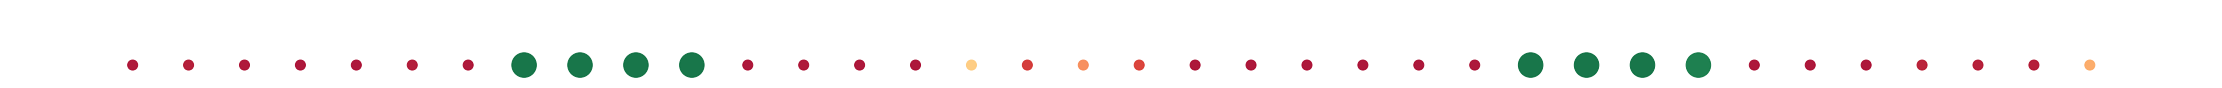

In [ ]:
#@title Plot entire waveform
def set_size(w,h, ax):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24,3))

# Create upper graph
ax1.plot(tensor.numpy(), color='white')
ax1.axis('off')

# Create bubbles
x_shift = stride_size//2
x = np.linspace(x_shift, clip_length - stride_size//2, num=n_segments)
y = np.ones(n_segments)
colors = predictions
area = 100 + is_marvins * 500
num = 1
ax2.scatter(x, y, s=area, c=colors, alpha=0.9, cmap='RdYlGn')
ax2.axis('off')
set_size(24, 1, ax=ax2)

# Plot figure
fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()
plt.ioff()

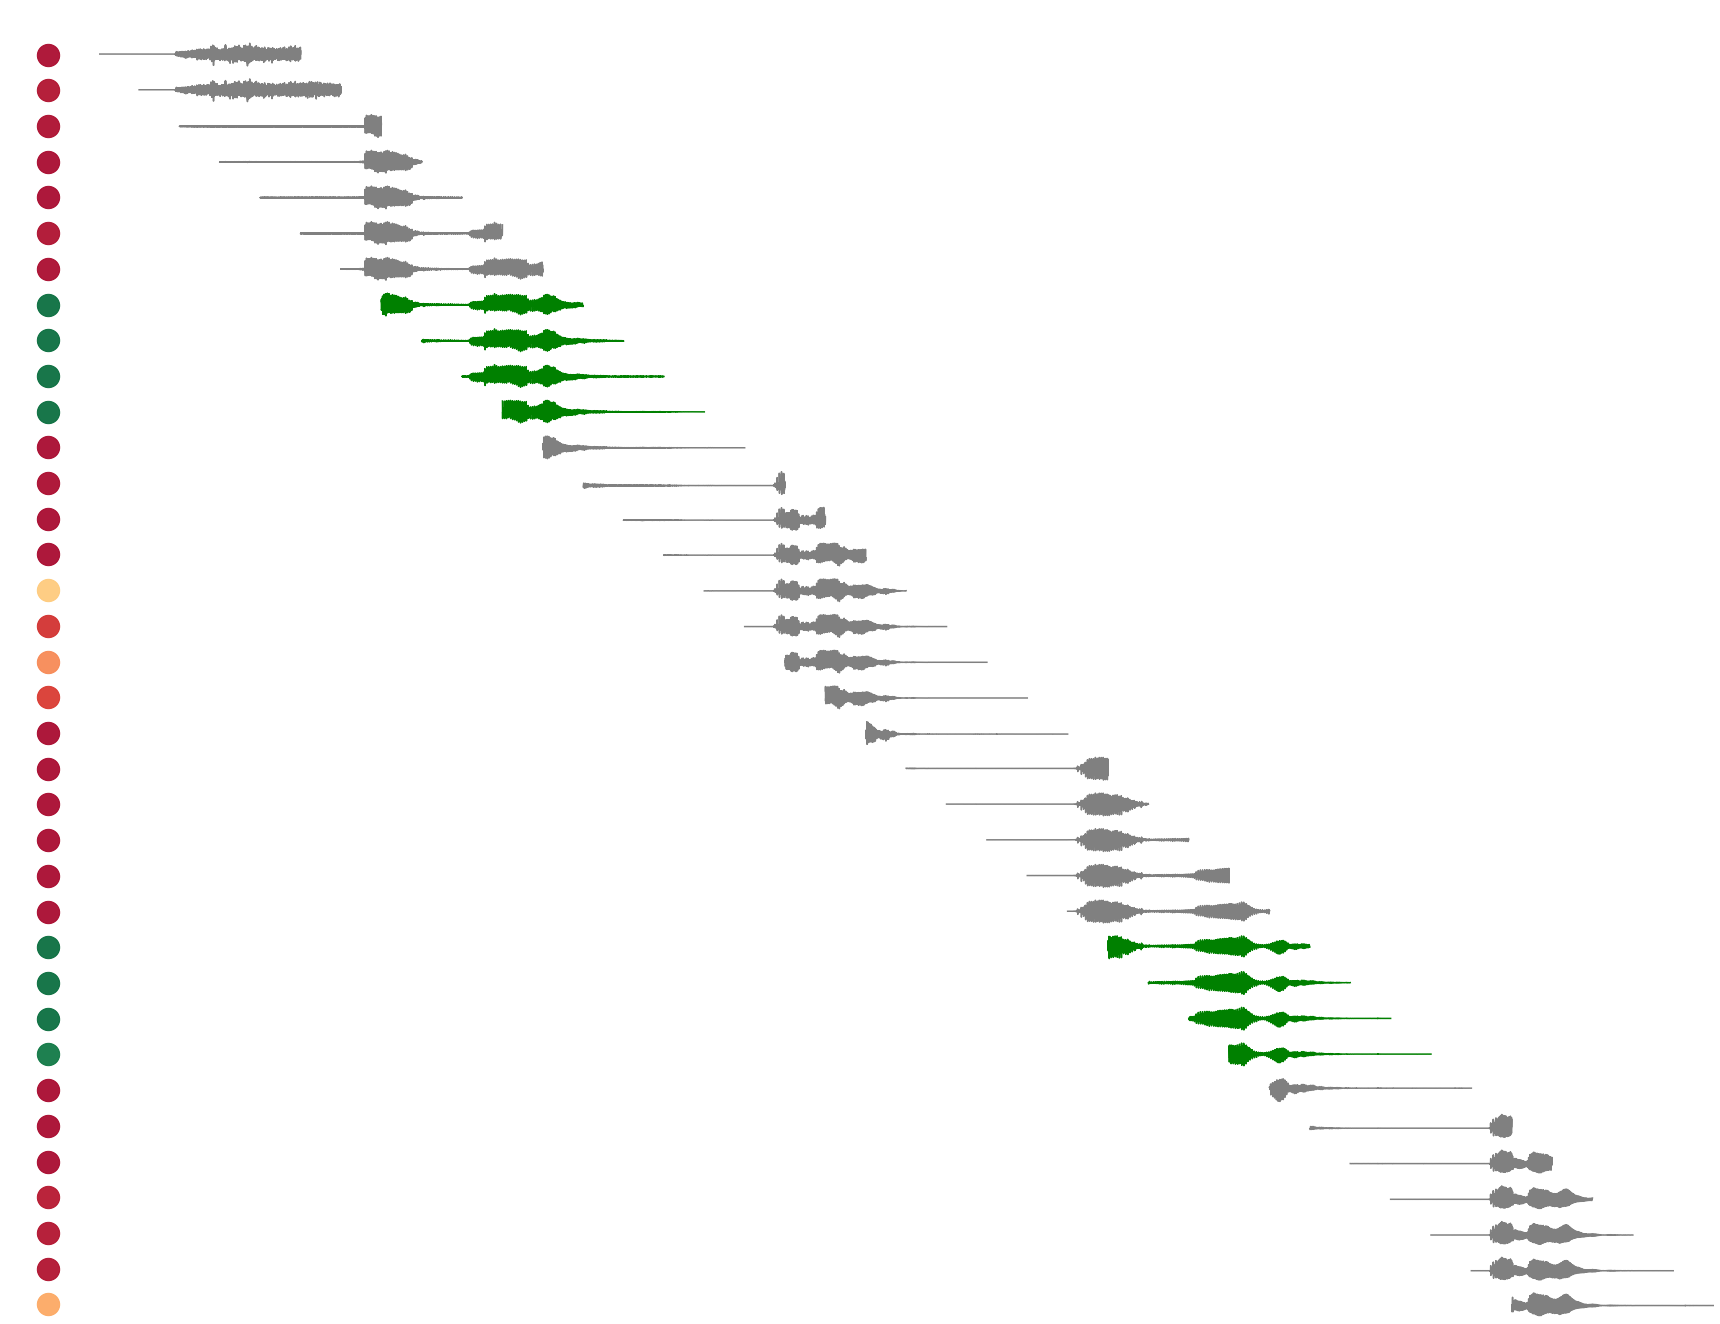

In [ ]:
#@title Plot segments


# Plot figure
FIG_WIDTH = 24

fig, axes = plt.subplots(n_segments + 1, 2, figsize=(FIG_WIDTH, (n_segments + 1)*0.5), gridspec_kw={'width_ratios':[1,20]})
axes_flat = axes.flat
axes[0, 0].axis('off')
top_axis = axes[0, 1]
top_axis.plot(tensor.numpy(), color='white')
top_axis.axis('off')
top_axis.set_xbound(0, clip_length)

def set_size(w,h, ax):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

for i, item in enumerate(zip(audio_dataset, predictions)):
    audio, prediction = item
    dot_ax, ax = axes_flat[2*(i+1):2*(i+2)]

    # Fetch data
    is_marvin = prediction > 0.5
    audio_data = audio.numpy().squeeze()
    x = np.arange(i*stride_size, i*stride_size + desired_sample_rate)

    # Create bubble
    colors = predictions
    area = 500 #100 + is_marvins * 500
    dot_ax.scatter([0], [0], s=area, c=[prediction], alpha=0.9, cmap='RdYlGn', vmin=0, vmax=1, )
    dot_ax.set_xlim(-1, 1)
    dot_ax.axis('off')
    #set_size(1, 1, ax=dot_ax)

    # Plot segment
    #set_size(FIG_WIDTH, 1*n_segments+1, ax)
    ax.plot(x, audio_data, color='green' if is_marvin else 'grey')
    ax.set_xbound(0, clip_length)
    ax.axis('off')
    ax.get_shared_x_axes().join(ax, top_axis)
fig.tight_layout(rect=[0, 0, 1, 1])

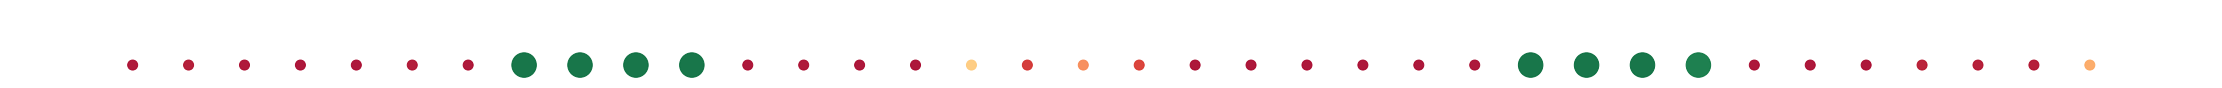

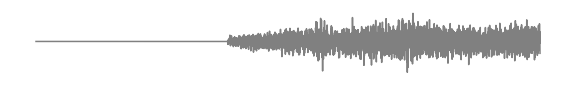

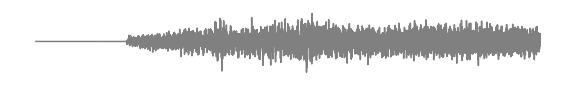

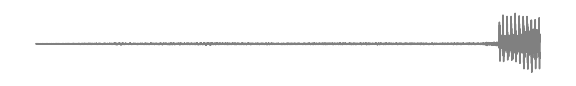

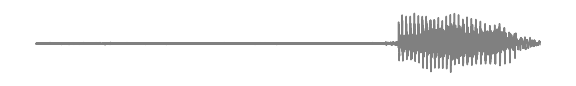

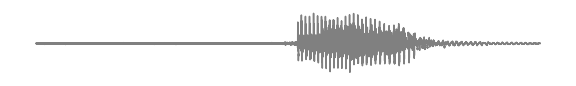

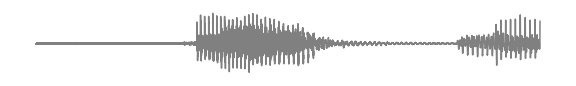

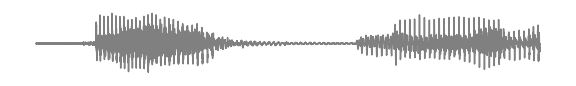

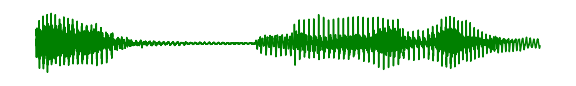

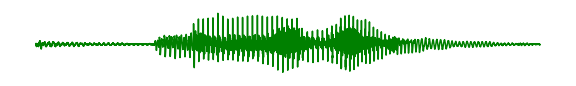

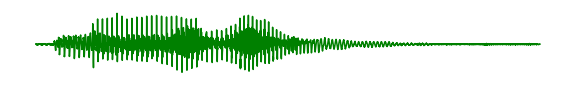

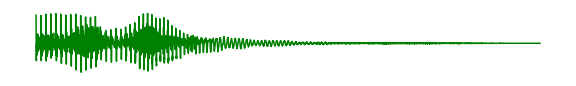

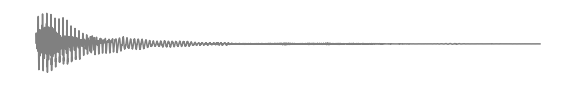

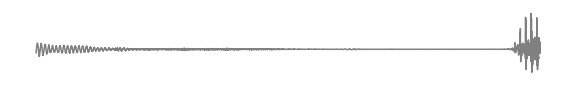

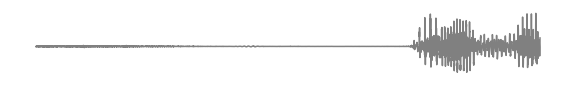

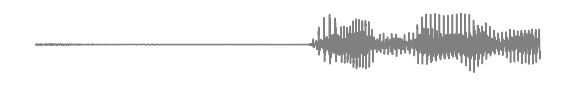

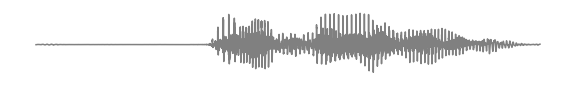

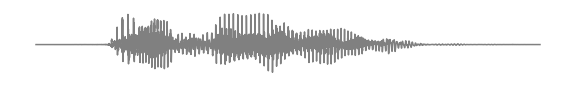

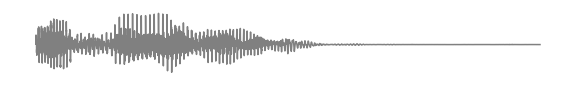

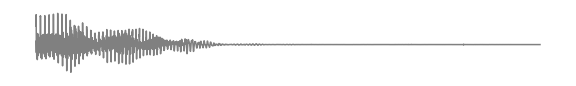

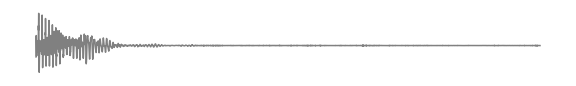

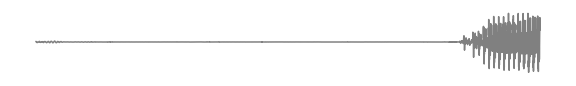

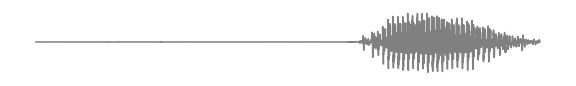

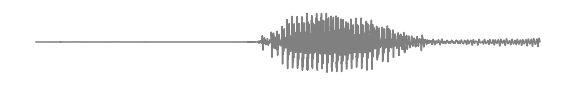

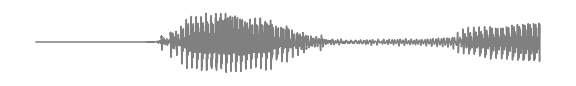

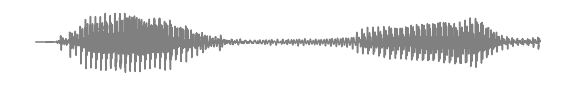

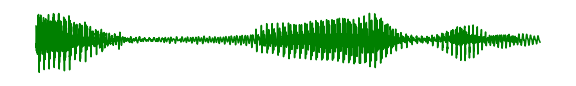

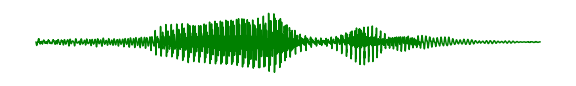

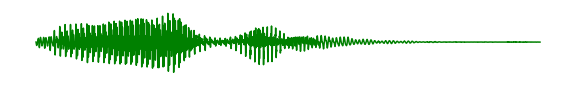

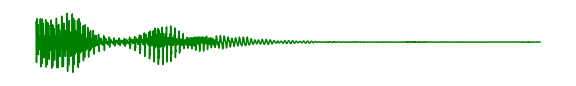

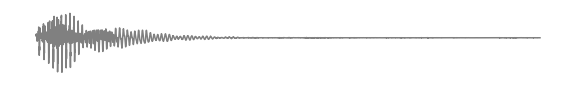

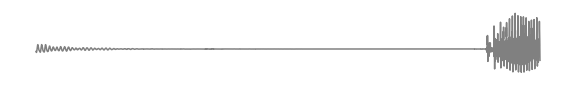

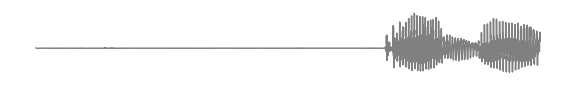

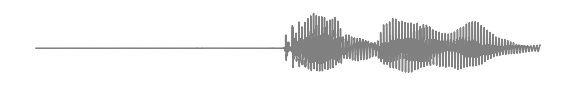

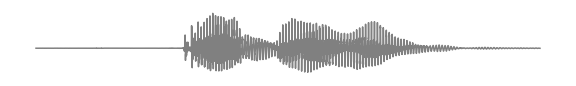

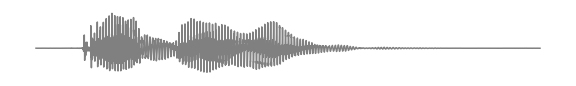

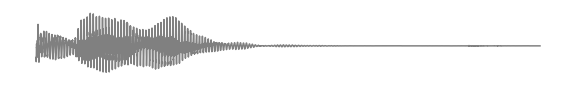

In [ ]:
#@title  Plot detailed audio pairs
def set_size(w,h, ax):
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

x_shift = stride_size//2
x = np.linspace(x_shift, clip_length - stride_size//2, num=n_segments)
y = np.ones(n_segments)
colors = predictions
area = 100 + is_marvins * 500

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(24,3))

ax1.plot(tensor.numpy(), color='white')
ax1.axis('off')

ax2.scatter(x, y, s=area, c=colors, alpha=0.9, cmap='RdYlGn')
ax2.axis('off')
set_size(24, 1, ax=ax2)

fig.tight_layout(rect=[0, 0, 1, 1])
plt.show()
plt.ioff()

# Visualize outputs
for i, item in enumerate(zip(audio_dataset, predictions)):
    audio, prediction = item
    is_marvin = prediction > 0.5
    audio_data = audio.numpy().squeeze()

    displays = []
    #displays.append(f"{str(is_marvin).capitalize()}")
    displays.append(display.Audio(audio_data, rate=16_000))

    buf = io.BytesIO()
    fig = plt.figure(figsize=(8,1.2))
    plt.plot(audio_data, color='green' if is_marvin else 'grey')
    plt.axis('off')
    fig.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(buf, format='png', transparent=True)
    plt.close(fig)
    buf.seek(0)

    displays.append(display.Image(buf.read()))
    display.display(*displays)
    print('\n')


##### TensorBoard

In [ ]:
#https://76bdzjdczr36-496ff2e9c6d22116-6006-colab.googleusercontent.com/#scalars
import tensorboard as tb
%reload_ext tensorboard
%tensorboard --logdir logs/rnn --port 6006
display.clear_output(wait=False)
tb.notebook.display(height=1400)